## Development-Kit Tutorial for Zenseact Open Dataset
This notebook aims to introduce the ZodFrames & ZodSequences classes, which are helper classes to interact with the Frames and Sequences subsets of the Zenseact Open Dataset (ZOD) respecively. It will highlight some basic functionality that later can be used to build dataloaders in for example PyTorch.

This notebook also aims to give a brief introduction to the which annotations exist and how to visualization them. 

#### The dataset includes data from 3 sensor modalities and calibrations for each sensor:  
1. **Camera** - Anonymized (license plates and faces) front camera images. Available anonymization methods are:
    - blur (Blur)
    - dnat (Deep Fake)


2. **LiDAR** - The LiDAR point cloud is the closest LiDAR scan to the camera timestamp of the core frame. Zenseact Open Dataset also provides a range of LiDAR point clouds captured in [-1s, +1s] at 10Hz around the core frame for the sequences.


3. **OXTS** - High-precision GPS. OXTS data is provided in [-1s, ~10s] around the core frames for each sequence.

#### There are 4 types of annotationed objects:  
1. **dynamic_objects** - objects that can move (vehicles, pedestrians etc.) - annotated with 2D/3D bounding boxes
2. **static_objects** - non-movable objects (light poles, traffic signs etc.) - annotated with 2D/3D bounding boxes
3. **lane_markings** - lane markings and road paitings - annotated with polygons
4. **ego_road** (Doesn't exist for all frames) - polygons that shows the road where ego vehicle can drive - annotated with polygons 

# Initialization


In [17]:
pip install opencv-python

     |████████████████████████████████| 55.7 MB 100 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install zod

     |████████████████████████████████| 95 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 11.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

# imports for plotting
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

# import the ZOD DevKit
from zod import ZodFrames
from zod import ZodSequences

# import default constants
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject

# import useful data classes
from zod.data_classes import LidarData

# NOTE! Set the path to dataset and choose a version
dataset_root = "/Users/hannaolsson/Desktop/OWOD/zodmini"
version = "mini"  # "mini" or "full"

# initialize ZodFrames
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)

# initialize ZodSequences
zod_sequences = ZodSequences(dataset_root=dataset_root, version=version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Split into Training and Validation sets

In [7]:
# get default training and validation splits
training_frames = zod_frames.get_split(constants.TRAIN)
validation_frames = zod_frames.get_split(constants.VAL)

# print the number of training and validation frames
print(f"Number of training frames: {len(training_frames)}")
print(f"Number of validation frames: {len(validation_frames)}")

training_sequences = zod_sequences.get_split(constants.TRAIN)
validation_sequences = zod_sequences.get_split(constants.VAL)
print(f"Number of training sequences: {len(training_sequences)}")
print(f"Number of validation sequences: {len(validation_sequences)}")

# print out the first 5 training frames
print("The 5 first training frames have the ids:", sorted(list(training_frames))[:5])

# show the first training sequence
print("The first training sequence has the id:", sorted(list(training_sequences))[0])

Number of training frames: 10
Number of validation frames: 2
Number of training sequences: 1
Number of validation sequences: 1
The 5 first training frames have the ids: ['009158', '018591', '023996', '029229', '044953']
The first training sequence has the id: 000000


# ZodFrames
### Fetch a ZodFrame
The ZodFrames class yeild a `ZodFrame` which acts a cache for the light-weight data (e.g., ego-motion, calibration, and metadata), but also holds an `info` attribute. This in turn holds all the paths to more heavy-weight data (e.g., images and point clouds).


In [8]:
# we can get a specific frame by its id
frame_from_id = zod_frames["009158"]
# or via the index
frame_from_idx = zod_frames[9158]

# these two frames are the same
assert frame_from_id.info == frame_from_idx.info

### Look at some data within a ZodFrame

In [9]:
zod_frame = zod_frames[62592]

# we can access the metadata of a frame
metadata = zod_frame.metadata

# print a subsample of meta data
print(f"Frame id: {metadata.frame_id}")
print(f"Country Code: {metadata.country_code}")
print(f"Time of day: {metadata.time_of_day}")
print(f"Number of vehicles in the frame: {metadata.num_vehicles}")

Frame id: 062592
Country Code: SE
Time of day: day
Number of vehicles in the frame: 1


In [10]:
# we can use the frame to get the OXTS of our the vehicle
oxts = zod_frame.oxts
print(f"Acceleration: {oxts.accelerations.shape}")
print(f"Velocities: {oxts.velocities.shape}")
print(f"Poses: {oxts.poses.shape}")
print(f"Timestamps: {oxts.timestamps.shape}")

Acceleration: (2792, 3)
Velocities: (2792, 3)
Poses: (2792, 4, 4)
Timestamps: (2792,)


In [11]:
# we can use the frame to get the ego-motion of our the vehicle
# note that the ego-motion is a lightwieght version of the oxts data
ego_motion = zod_frame.ego_motion
print(f"Acceleration: {ego_motion.accelerations.shape}")
print(f"Velocities: {ego_motion.velocities.shape}")
print(f"Poses: {ego_motion.poses.shape}")
print(f"Timestamps: {ego_motion.timestamps.shape}")

Acceleration: (22, 3)
Velocities: (22, 3)
Poses: (22, 4, 4)
Timestamps: (22,)


In [12]:
# The upper-left 3x3 matrix is the rotation matrix
rotation_matrix = zod_frame.ego_motion.poses[0, :3, :3]
print(rotation_matrix)

# The last column contain the translation
translation = zod_frame.ego_motion.poses[0, :3, -1]
print(translation)

[[ 0.52595988 -0.84979826  0.0347724 ]
 [ 0.85027106  0.52634065  0.00215414]
 [-0.02013272  0.02843298  0.99939294]]
[24.85092623 -5.62102544 -0.82356965]


In [13]:
# we can also get the calibrations
calibrations = zod_frame.calibration

print(calibrations.lidars[Lidar.VELODYNE])
print(calibrations.cameras[Camera.FRONT])

LidarCalibration(extrinsics=Pose(transform=array([[-2.66972782e-02,  9.99642575e-01,  1.40631277e-03,
         1.05952156e+00],
       [-9.99622790e-01, -2.66876273e-02, -6.48452352e-03,
        -6.12873327e-03],
       [-6.44467464e-03, -1.57890142e-03,  9.99977986e-01,
         1.71154659e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])))
CameraCalibration(extrinsics=Pose(transform=array([[ 0.00717325,  0.00832605,  0.99993961,  2.05513307],
       [-0.9998231 ,  0.01744657,  0.00702714, -0.00234948],
       [-0.01738701, -0.99981313,  0.00844973,  1.1285097 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])), intrinsics=array([[1.85561168e+03, 0.00000000e+00, 1.91878275e+03, 0.00000000e+00],
       [0.00000000e+00, 1.85561168e+03, 1.06901948e+03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]), distortion=array([-0.01899782,  0.00485484,  0.00112781, -0.00099395]), undistortion=array(

#### Camera Data 

In [14]:
# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.DNAT)
print(camera_core_frame)

{
  "filepath": "/Users/hannaolsson/Desktop/OWOD/zodmini/single_frames/062592/camera_front_dnat/062592_india_2021-01-17T11:19:08.447181Z.jpg",
  "time": "2021-01-17T11:19:08.447181Z",
  "height": 2168,
  "width": 3848
}


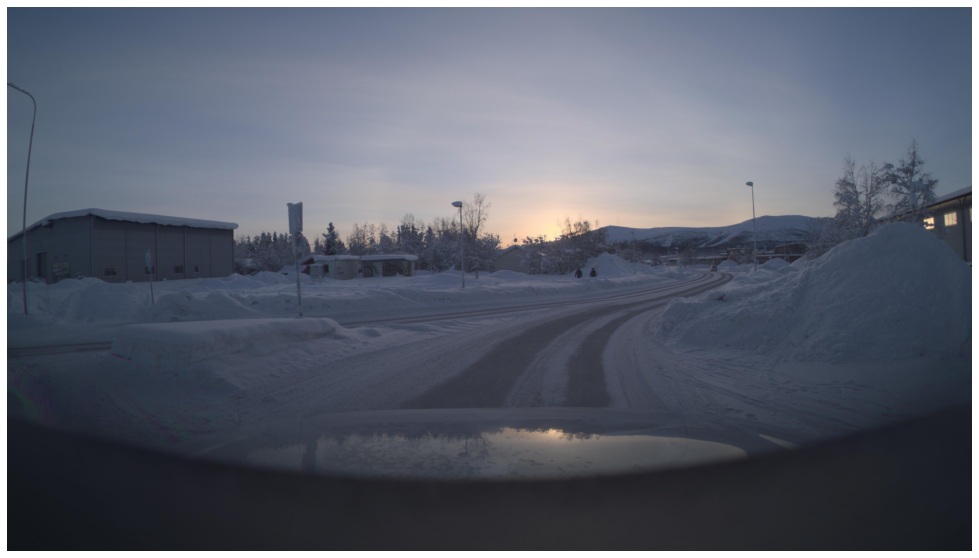

In [15]:
# one can read the image from the filepath
image = camera_core_frame.read()
# or use a helper directly from the frame
image = zod_frame.get_image(Anonymization.DNAT)

plt.axis("off")
plt.imshow(image)
plt.show()

#### Ego Position Data

Number of points: 1308
Number of points in fov: 1296


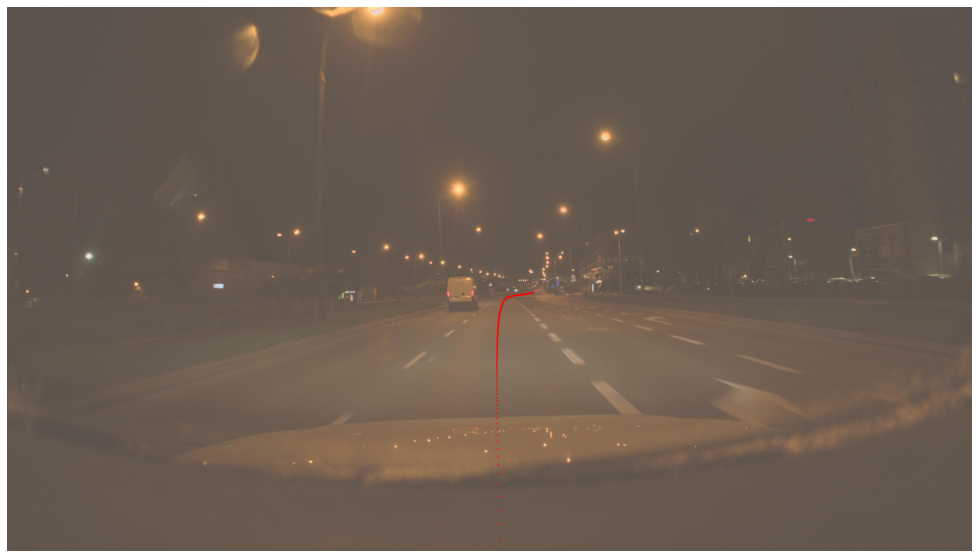

In [18]:
from zod.visualization.oxts_on_image import visualize_oxts_on_image
import numpy as np
import cv2

zod_frame = zod_frames["082291"]

# extract the oxts data
oxts = zod_frame.oxts

# visualize the oxts data on the image
calibrations = zod_frame.calibration

# get the time of the keyframe (into which we want to project the oxts points)
key_timestamp = zod_frame.info.keyframe_time.timestamp()

image = zod_frame.get_image(Anonymization.DNAT)
image = visualize_oxts_on_image(oxts, key_timestamp, calibrations, image, camera=Camera.FRONT)

plt.axis("off")
plt.imshow(image)
plt.show()

#### LiDAR Data
Lidar fields description:

| Name | Type | Units | Description |
| --- | --- | --- | --- |
| 'timestamp' | string |  seconds  | UTC timestamp of each point. |
| 'x' | double |  meters  | x coordinate of the point in lidar frame |
| 'y' | double |  meters  | y coordinate of the point in lidar frame |
| 'z' | double |  meters  | z coordinate of the point in lidar frame |
| 'intensity' | double |    | intensity level of each point in range [0..255] |
| 'diode_index' | integer |    | index of diode emitter which produced a point (1..128) |

In [ ]:
zod_frame = zod_frames[62592]

# get the lidar core-frame
lidar_core_frame = zod_frame.info.get_key_lidar_frame()
print(lidar_core_frame)

In [ ]:
# load the lidar data
pc = lidar_core_frame.read()

# LidarData dataclass is a wrapper around several numpy arrays
assert isinstance(pc, LidarData)

# alternatively, we can use helper functions on the frame itself
assert zod_frame.get_lidar()[0] == pc
assert zod_frame.get_lidar_frames()[0].read() == pc

print(f"Points: {pc.points.shape}")  # x, y, z
print(f"Timestamps: {pc.timestamps.shape}")
print(f"Intensity: {pc.intensity.shape}")
print(f"Diode: {pc.diode_idx.shape}")

# TODO: add visualization, e.g. 3d scatter plot with plotly

# Annotations


In [78]:
# get a new frame
zod_frame = zod_frames["082291"]

# get the object annotations
annotations = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)

# get a single annotation object by index
idx = 31
print(f"Annotation: {annotations[idx].name}")

# there are both 2d and 3d annotations
annotation_2d = annotations[idx].box2d
annotation_3d = annotations[idx].box3d
print(annotation_2d)
print(annotation_3d)

Annotation: Vehicle
Box2D(xyxy=array([1753.9 , 1074.95, 1887.03, 1209.96], dtype=float32), frame=<Camera.FRONT: 'front'>)
Box3D(center=array([-3.38932003, 38.7134852 , -0.56041962]), size=array([6.17122   , 2.28448417, 2.57618055]), orientation=Quaternion(0.7097492611432574, 0.003950360067184064, 0.003902715230673673, 0.7044325019302901), frame=<Lidar.VELODYNE: 'velodyne'>)


In [76]:
#MAP FRAMES TO ONLY DYNAMIC ANNOTATIONS
def only_dynamic(zod_frames):
    new_annotations_per_frame = {}
    dynamic_objects = ["Vehicle", "VulnerableVehicle", "Pedestrian", "Animal"]
    for frame in zod_frames: 
        annotations = frame.get_annotation(AnnotationProject.OBJECT_DETECTION)
        filtered_annotations = [annotation for annotation in annotations if annotation.name in dynamic_objects]
        new_annotations_per_frame[frame.info.id] = filtered_annotations
        #print("Object_loss: ", len(annotations)-len(filtered_annotations))
        #print(filtered_annotations)
    
    return new_annotations_per_frame

   

new_annotations = only_dynamic(zod_frames)
#Each frame mapped to its new annoations
new_annotations

('009158',
 [ObjectAnnotation(box2d=Box2D(xyxy=array([2082.062 , 1117.2623, 2208.6108, 1224.4728], dtype=float32), frame=<Camera.FRONT: 'front'>), unclear=False, name='Vehicle', uuid='0aee66f4-183d-4227-9595-02749b03fdd6', box3d=Box3D(center=array([ 3.26 , 28.038, -1.311]), size=array([4.   , 2.   , 1.565]), orientation=Quaternion(0.7071067811865476, 0.0, 0.0, 0.7071067811865475), frame=<Lidar.VELODYNE: 'velodyne'>), object_type='Car', occlusion_level='Medium', artificial=None, with_rider=None, emergency=False, traffic_content_visible=None),
  ObjectAnnotation(box2d=Box2D(xyxy=array([1539.6193, 1094.5775, 1702.3185, 1217.6743], dtype=float32), frame=<Camera.FRONT: 'front'>), unclear=False, name='Vehicle', uuid='1336e4e8-2945-4b06-bdb2-dd2f4ff101d1', box3d=Box3D(center=array([-5.158, 32.418, -1.356]), size=array([5.321, 2.174, 1.922]), orientation=Quaternion(-0.7033866208620028, 0.0, 0.0, 0.7108074715366555), frame=<Lidar.VELODYNE: 'velodyne'>), object_type='Van', occlusion_level='Mediu

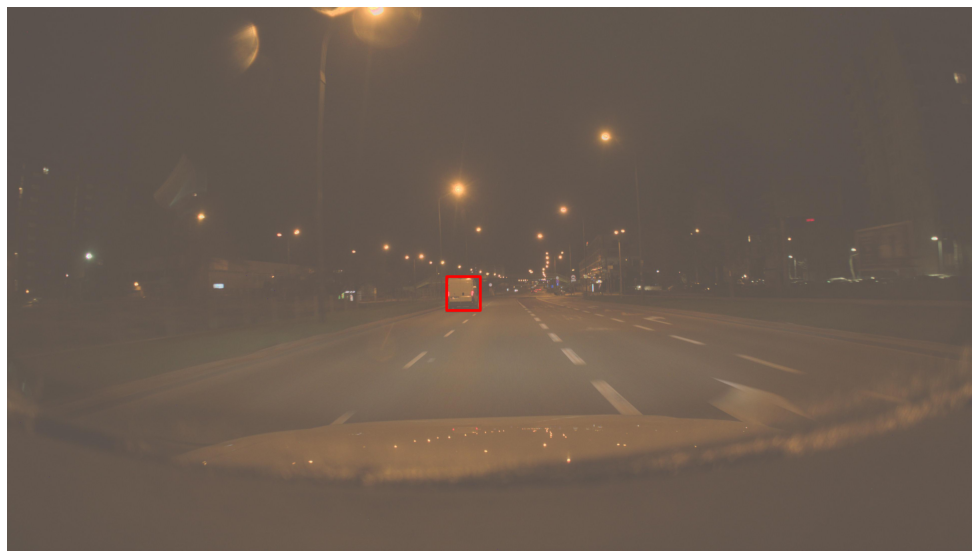

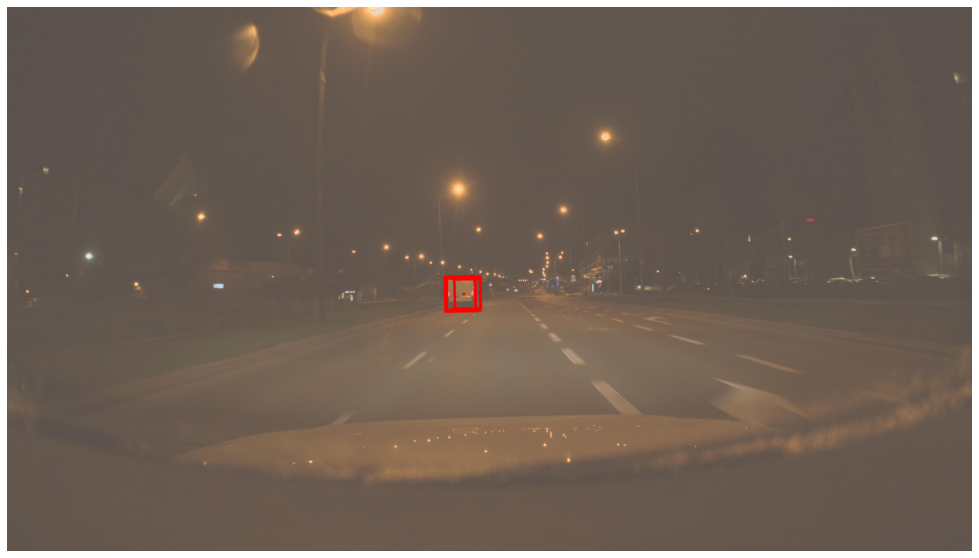

In [20]:
from zod.visualization.object_visualization import overlay_object_2d_box_on_image
from zod.visualization.object_visualization import overlay_object_3d_box_on_image

# we can overlay the 2d annotation on the front camera image
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.DNAT)
image = camera_core_frame.read()

image = overlay_object_2d_box_on_image(image, annotation_2d, color=(255, 0, 0), line_thickness=10)

plt.figure()
plt.axis("off")
plt.imshow(image)

# we can also overlay the 3d annotation on the front camera image,
# but for this we also need the calibrations of the sensor
calibrations = zod_frame.calibration

# overlay the 3d box on the image
image = overlay_object_3d_box_on_image(
    image, annotation_3d, calibrations, color=(255, 0, 0), line_thickness=10
)

plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

In [21]:
from zod.utils.polygon_transformations import polygons_to_binary_mask

zod_frame = zod_frames[9158]

# get the ego road annotations
polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)

# convert the polygons to a binary mask (which can be used
# for ground truth in e.g. semantic segmentation)
mask = polygons_to_binary_mask(polygon_annotations)

# visualize the mask
plt.axis("off")
plt.imshow(mask)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'type'

In [ ]:
# get another frame
zod_frame = zod_frames[23996]

# get the lane markings annotations
project = constants.AnnotationProject.LANE_MARKINGS
annotations = zod_frame.get_annotation(project)
polygons = [anno.geometry for anno in annotations]

# convert the polygons to a binary mask
mask = polygons_to_binary_mask(polygons)

# visualize the mask
plt.axis("off")
plt.imshow(mask)
plt.show()

In [ ]:
# We can overlay the ego road annotations on the image
from zod.visualization.polygon_utils import overlay_mask_on_image
from zod.utils.polygon_transformations import polygons_to_binary_mask

zod_frame = zod_frames[9158]

# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.DNAT)

# get the image
image = camera_core_frame.read()

# get the ego road annotations
polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)

# convert the polygons to a binary mask (which can be used
# for ground truth in e.g. semantic segmentation)
mask = polygons_to_binary_mask(polygon_annotations)

# overlay the mask on the image
image = overlay_mask_on_image(mask, image, fill_color=(100, 0, 0), alpha=0.5)

# visualize the mask
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# we can overlay the lane markings annotations on the image
zod_frame = zod_frames[29229]

# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.DNAT)

# get the image
image = camera_core_frame.read()

# get the ego road annotations
lane_annotations = zod_frame.get_annotation(AnnotationProject.LANE_MARKINGS)
lane_polygons = [lane.geometry for lane in lane_annotations]

# convert the polygons to a binary mask (which can be used
# for ground truth in e.g. semantic segmentation)
mask = polygons_to_binary_mask(lane_polygons)

# overlay the mask on the image
image = overlay_mask_on_image(mask, image, fill_color=(0, 0, 100), alpha=0.75)

# visualize the mask
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# Visualize LiDAR and objects in Bird's Eye View
from zod.visualization.lidar_bev import BEVBox

zod_frame = zod_frames["009158"]

# get the LiDAR point cloud
pcd = zod_frame.get_lidar()[0]

# get the object annotations
object_annotations = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)

import numpy as np

bev = BEVBox()
bev_image = bev(
    np.hstack((pcd.points, pcd.intensity[:, None])),
    (
        np.array([obj.name for obj in object_annotations if obj.box3d]),
        np.concatenate(
            [obj.box3d.center[None, :] for obj in object_annotations if obj.box3d], axis=0
        ),
        np.concatenate(
            [obj.box3d.size[None, :] for obj in object_annotations if obj.box3d], axis=0
        ),
        np.array([obj.box3d.orientation for obj in object_annotations if obj.box3d]),
    ),
)

In [ ]:
# we can also visualize the lidar point cloud in the image
from zod.visualization.lidar_on_image import visualize_lidar_on_image

zod_frame = zod_frames["087912"]

image = zod_frame.get_image()
image_timestamp = zod_frame.info.keyframe_time.timestamp()

# Get a single Lidar point cloud
core_lidar = zod_frame.get_lidar()[0]
# Motion-compensate it to the image timestamp (minorly improves alignment)
compensated_lidar = zod_frame.compensate_lidar(core_lidar, image_timestamp)
# Visualize by projecting the point cloud onto the image
lid_image = visualize_lidar_on_image(
    core_lidar,
    zod_frame.calibration,
    image,
)
plt.axis("off")
plt.title("Core LIDAR projected onto image")
plt.imshow(lid_image)
plt.show()

# Plot aggregated Lidar point cloud
aggregated_lidar = zod_frame.get_aggregated_lidar(
    num_before=10, num_after=0, timestamp=image_timestamp
)
lid_image = visualize_lidar_on_image(
    aggregated_lidar,
    zod_frame.calibration,
    image,
)
plt.axis("off")
plt.title("Aggregated LIDAR projected onto image")
plt.imshow(lid_image)
plt.show()

In [ ]:
# we can also visualize all together
zod_frame = zod_frames[9158]

pcd = zod_frame.get_aggregated_lidar(num_before=3)
annotations = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)
polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)
mask = polygons_to_binary_mask(polygon_annotations)
calibrations = zod_frame.calibration
image = zod_frame.get_image(Anonymization.DNAT)

# overlay the mask/annotation/pointcloud on the image
image = visualize_lidar_on_image(pcd, calibrations, image)
image = overlay_mask_on_image(mask, image, fill_color=(100, 0, 0), alpha=0.5)
for annotation in annotations:
    if annotation.box3d:
        image = overlay_object_3d_box_on_image(
            image, annotation.box3d, calibrations, color=(0, 100, 0), line_thickness=10
        )
plt.axis("off")
plt.imshow(image)
plt.show()

# ZodSequence
Visualization functionality for ZodFrames also works on sequences. Let's take a quick look.

### Fetch a ZodSequence
The ZodSequences class yeild a `ZodSequence` which acts a cache for the light-weight data (e.g., ego-motion, calibration, and metadata), but also holds an `info` attribute. This in turn holds all the paths to more heavy-weight data (e.g., images and point clouds) for all timesteps in the sequence. Note that annotations are only provided for a single frame, namely the `key_frame`.



In [ ]:
# We can do the same for the sequences
seq = zod_sequences[list(validation_sequences)[0]]

# Get the lidar frames
print(f"Number of lidar frames: {len(seq.info.get_lidar_frames(lidar=Lidar.VELODYNE))}")
# We can also get the original camera frames
print(f"Number of camera frames: {len(seq.info.get_camera_frames())}")

# Or see how long the sequence is
print(f"Timespan: {(seq.info.end_time - seq.info.start_time).total_seconds()}")

In [ ]:
from zod.visualization.lidar_on_image import visualize_lidar_on_image

# get the key frames
key_camera_frame = seq.info.get_key_camera_frame()

# get the annotations (when they are ready...)
try:
    annotations = seq.get_annotation(AnnotationProject.OBJECT_DETECTION)
except:
    annotations = []

image = key_camera_frame.read()
pcd = seq.get_compensated_lidar(key_camera_frame.time)

image = visualize_lidar_on_image(
    pcd,
    seq.calibration,
    image,
)

for annotation in annotations:
    if annotation.box3d:
        image = overlay_object_3d_box_on_image(
            image, annotation.box3d, seq.calibration, color=(0, 100, 0), line_thickness=10
        )

plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# we can also visualize the entire sequence
draw_every_nth = 5  # (Only visualization every nth frame for speed...)

# get the mapping between camera and lidar frames
frames = seq.info.get_camera_lidar_map()

images = []
# iterate over the frames
for i, frame in enumerate(frames):
    if i % draw_every_nth == 0:
        camera_frame, lidar_frame = frame

        img = camera_frame.read()
        pcd = seq.get_compensated_lidar(camera_frame.time)

        lid_image = visualize_lidar_on_image(
            pcd,
            seq.calibration,
            img,
        )
        images.append(img)

In [ ]:
# Create a gif with all the frames (requires imageio)
from IPython.core.display import Image
import imageio

imageio.mimsave("test.gif", images, duration=0.2)
Image(filename="test.gif")